<a href="https://colab.research.google.com/github/PotatoSpudowski/Graph_convolution_basics/blob/master/Node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("Gpu name: "+ gpu.name +"| GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=75b6d90733e7c7a511dff052eb680b590f80aa780cecb2cd66ec4e9250e87ca8
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 158.7 MB
Gpu name: Tesla P100-PCIE-16GB| GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 1.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 15.2MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 14.5MB 239kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 5.1MB 300kB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 348kB 31.5MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.3-cp36-none-any.whl size=234873 sha256=b9198fff5a6f68380a65e424a06e97b151e142bdaebd24f6f4423cd14de83cd8
  Stored in directory: /root/.cache/pip/wheels/e2/c1/09/8693feee3f97e440d68b09abfca8b4c1e97150ace350b5003f
Successfully built torch-geometric


In [0]:
import numpy as np
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SplineConv
from torch_geometric.data import Data
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Spammer
nb_nbrs = int(random.random() * (2000/5))
print("No of Neighbours: {}".format(nb_nbrs))
print("Amount of bytes sent: {}".format((random.random()+1) / 2.))
print("Trust value: {}".format([(random.random()+2)/3.] * nb_nbrs))

No of Neighbours: 249
Amount of bytes sent: 0.824293875111876
Trust value: [0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.9654349416163678, 0.96

In [5]:
#Normal user
nb_nbrs = int(random.random() * 10 + 1)
print("No of Neighbours: {}".format(nb_nbrs))
print("Amount of bytes sent: {}".format(random.random()))
print("Trust value: {}".format([random.random()] * nb_nbrs))

No of Neighbours: 1
Amount of bytes sent: 0.6034513050290943
Trust value: [0.96808120677849]


In [0]:
def generate_social_media_network(N):
    labels = []
    nodes = range(0, N)
    node_features = []
    edge_features = []

    for node in nodes:
  
        #spammer 
        if random.random() > 0.5:
            #more likely to have many connections with a maximum of 1/5 of the nodes in the graph 
            nb_nbrs = int(random.random() * (N/5))
            #more likely to have sent many bytes
            node_features.append((random.random()+1) / 2.)
            #more likely to have a high trust value 
            edge_features += [(random.random()+2)/3.] * nb_nbrs
            #associate a label 
            labels.append(1)

        #non-spammer 
        else:
            #at most connected to 10 nbrs 
            nb_nbrs = int(random.random() * 10 + 1)
            #associate more bytes and random bytes 
            node_features.append(random.random())
            edge_features += [random.random()] * nb_nbrs
            labels.append(0)

        #connect to some random nodes 
        nbrs = np.random.choice(nodes, size = nb_nbrs)
        nbrs = nbrs.reshape((1, nb_nbrs))

        #add the edges of nbrs 
        node_edges = np.concatenate([np.ones((1, nb_nbrs), dtype = np.int32) * node, nbrs], axis = 0)

        #add the overall edges 
        if node == 0:
            edges = node_edges
        else:
            edges = np.concatenate([edges, node_edges], axis = 1)

    return node_features, labels, edges, edge_features

In [0]:
no_of_nodes = 200
node_features, labels, edges, edge_features = generate_social_media_network(no_of_nodes)

G=nx.Graph()

for i in range(0, no_of_nodes):
    G.add_node(i)

source, destination = edges[0], edges[1]
for i in range(len(source)):
    G.add_edge(source[i],destination[i])

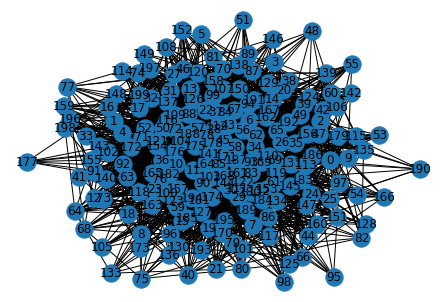

In [8]:
nx.draw(G, with_labels=True)

In [0]:
no_of_nodes = 2000
node_features, labels, edges, edge_features = generate_social_media_network(no_of_nodes)

In [0]:
x = torch.tensor(np.expand_dims(node_features, 1), dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

In [0]:
edge_index = torch.tensor(edges, dtype=torch.long)
edge_attr = torch.tensor(np.expand_dims(edge_features, 1), dtype=torch.float)

In [12]:
data = Data(x = x, edge_index=edge_index, y =y, edge_attr=edge_attr )
print(data)

Data(edge_attr=[211163, 1], edge_index=[2, 211163], x=[2000, 1], y=[2000])


In [0]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.train_mask[:int(0.8 * data.num_nodes)] = 1 #train only on the 80% nodes
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.uint8) #test on 20 % nodes 
data.test_mask[- int(0.2 * data.num_nodes):] = 1

In [0]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = SplineConv(1, 16, dim=1, kernel_size=5)
        self.conv2 = SplineConv(16, 32, dim=1, kernel_size=5)
        self.conv3 = SplineConv(32, 64, dim=1, kernel_size=7)
        self.conv4 = SplineConv(64, 128, dim=1, kernel_size=7)
        self.conv5 = SplineConv(128, 128, dim=1, kernel_size=11)
        self.conv6 = SplineConv(128, 2, dim=1, kernel_size=11)

    def forward(self):
        x, edge_index, edge_attribute = data.x, data.edge_index, data.edge_attr
        x = F.elu(self.conv1(x, edge_index, edge_attribute))
        x = self.conv2(x, edge_index, edge_attribute)
        x = F.elu(self.conv3(x, edge_index, edge_attribute))
        x = self.conv4(x, edge_index, edge_attribute)
        x = F.elu(self.conv5(x, edge_index, edge_attribute))
        x = self.conv6(x, edge_index, edge_attribute)
        x = F.dropout(x, p=0.4)
        x = F.log_softmax(x, dim=1)

        return x

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(1, 16, dim=1, kernel_size=5)
        self.conv2 = SplineConv(16, 32, dim=1, kernel_size=5)
        self.conv3 = SplineConv(32, 64, dim=1, kernel_size=7)
        self.conv4 = SplineConv(64, 128, dim=1, kernel_size=7)
        self.conv5 = SplineConv(128, 128, dim=1, kernel_size=11)
        self.conv6 = SplineConv(128, 2, dim=1, kernel_size=11)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(self.conv5(x, edge_index, edge_attr))
        x = self.conv6(x, edge_index, edge_attr)
        x = F.dropout(x, training = self.training)
        return F.log_softmax(x, dim=1)

In [0]:
def evaluate_loss(mode = 'train'):
    if mode == 'train':
        loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    else:
        loss = F.nll_loss(model()[data.test_mask], data.y[data.test_mask])
    return loss

def train():
    model.train()
    optimizer.zero_grad()
    loss = evaluate_loss()
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy() 

def test():
    model.eval()
    logits, accs = model(), []
    loss = evaluate_loss(mode = 'test').detach().cpu().numpy() 

    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return [loss] + accs

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
losses = []
for epoch in range(1, 200):
    train_loss = train()
    log = 'Epoch: {:03d}, train_loss: {:.3f}, test_loss:{:.3f}, train_acc: {:.2f}, test_acc: {:.2f}'
    test_loss = test()[0]
    losses.append([train_loss,test_loss])
    print(log.format(epoch, train_loss, *test()))

Epoch: 001, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 002, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 003, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 004, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 005, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 006, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 007, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 008, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 009, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 010, train_loss: 0.692, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 011, train_loss: 0.693, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 012, train_loss: 0.692, test_loss:0.693, train_acc: 0.51, test_acc: 0.50
Epoch: 013, train_loss: 0.692, test_loss